### Problem Statement:

The goal of this project is to give people an estimate of how much they need based on
their individual health situation. After that, customers can work with any health 
insurance carrier and its plans and perks while keeping the projected cost from our 
study in mind. This can assist a person in concentrating on the health side of an 
insurance policy rather han the ineffective part.


### Features of the Dataset:

**1. Age:** Insured Person's age in years.

**2. Sex:** Insured Person's gender(Male or Female).

**3. BMI:** Body mass index of the Insured Person.

**4. Children:** Children of the Insured Person.

**5. Smoker:** Insured Person is smoking or not.

**6. Region:** Insured Person belongs to which region.

**7. Expenses:** Expenses of the insured person.

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline,Pipeline
from xgboost import XGBRegressor
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.exceptions import NotFittedError

# to display the pipeline
from sklearn import set_config
set_config(display='diagram')

In [63]:
insurance_df = pd.read_csv("C:\\Users\\acer\\FSDS\\PROJECTS\\ML\\insurance_premium_prediction\\insurance_premium_dataset\\insurance.csv")
print("Shape of the dataset: ",insurance_df.shape, "\n")
print(insurance_df.head())

Shape of the dataset:  (1338, 7) 

   age     sex   bmi  children smoker     region  expenses
0   19  female  27.9         0    yes  southwest  16884.92
1   18    male  33.8         1     no  southeast   1725.55
2   28    male  33.0         3     no  southeast   4449.46
3   33    male  22.7         0     no  northwest  21984.47
4   32    male  28.9         0     no  northwest   3866.86


In [64]:
## statistical info of the dataset

## numerical data
insurance_df.describe()

,age,bmi,children,expenses
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.665471,1.094918,13270.422414
std,14.049960,6.098382,1.205493,12110.011240
min,18.000000,16.000000,0.000000,1121.870000
25%,27.000000,26.300000,0.000000,4740.287500
50%,39.000000,30.400000,1.000000,9382.030000
75%,51.000000,34.700000,2.000000,16639.915000
max,64.000000,53.100000,5.000000,63770.430000


In [65]:
## categorical data
insurance_df.describe(include="O")

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


In [66]:
insurance_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


### Handle missing values

In [67]:
insurance_df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
expenses    0
dtype: int64

#### Observation:1
  
  Total no of records: 1338

  numerical features: age, bmi, children, expenses
  
  categorical feature: sex, smoker, region

So, there are no missing values present in the dataset

### Check for duplicate reords

In [68]:
insurance_df.duplicated().sum()

1

In [69]:
insurance_df.drop_duplicates(inplace = True)

In [70]:
insurance_df.shape

(1337, 7)

### Univariate Analysis

In [71]:
data = insurance_df.copy()
data.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


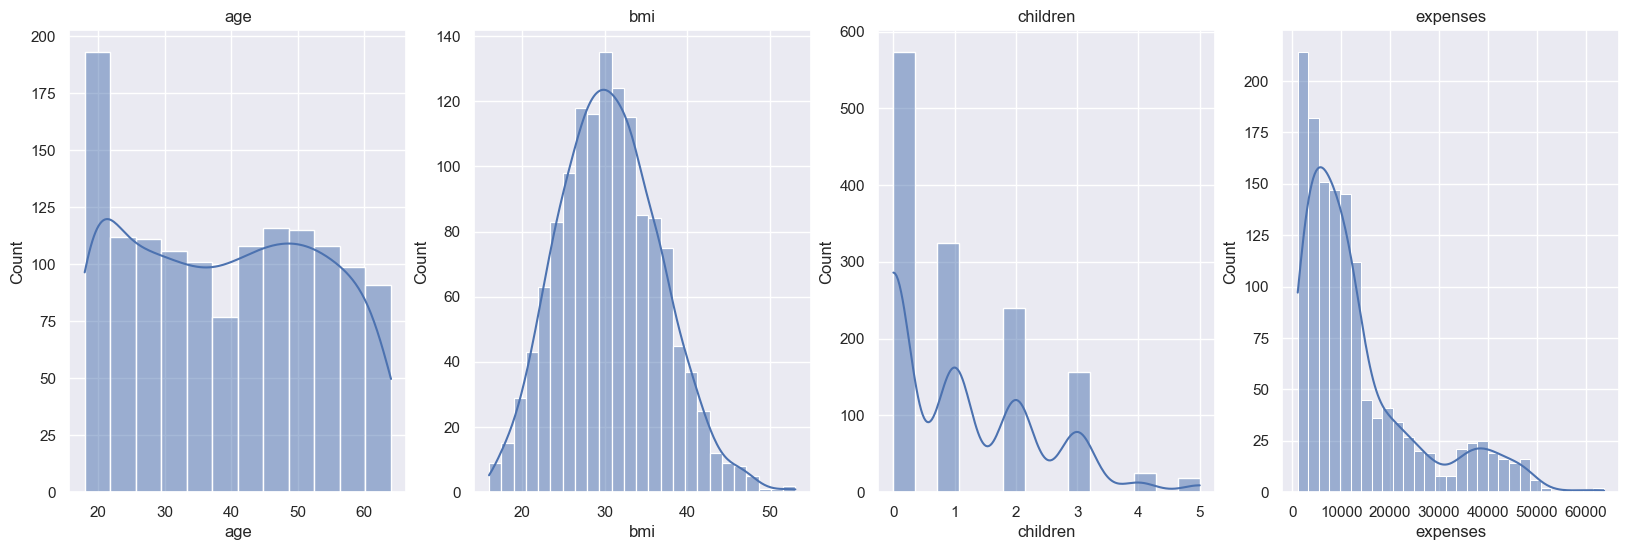

In [72]:
fig, axes = plt.subplots(1,4)   
axes = axes.flatten()        
fig.set_size_inches(20,6)
num_col = [col for col in data.columns if data[col].dtype!="O"]

for ax, col in zip(axes,num_col):

  sns.set_style("darkgrid", {"axes.facecolor": ".5"})
  sns.histplot(data[col], ax = ax,kde= True)
  ax.set_title(col)

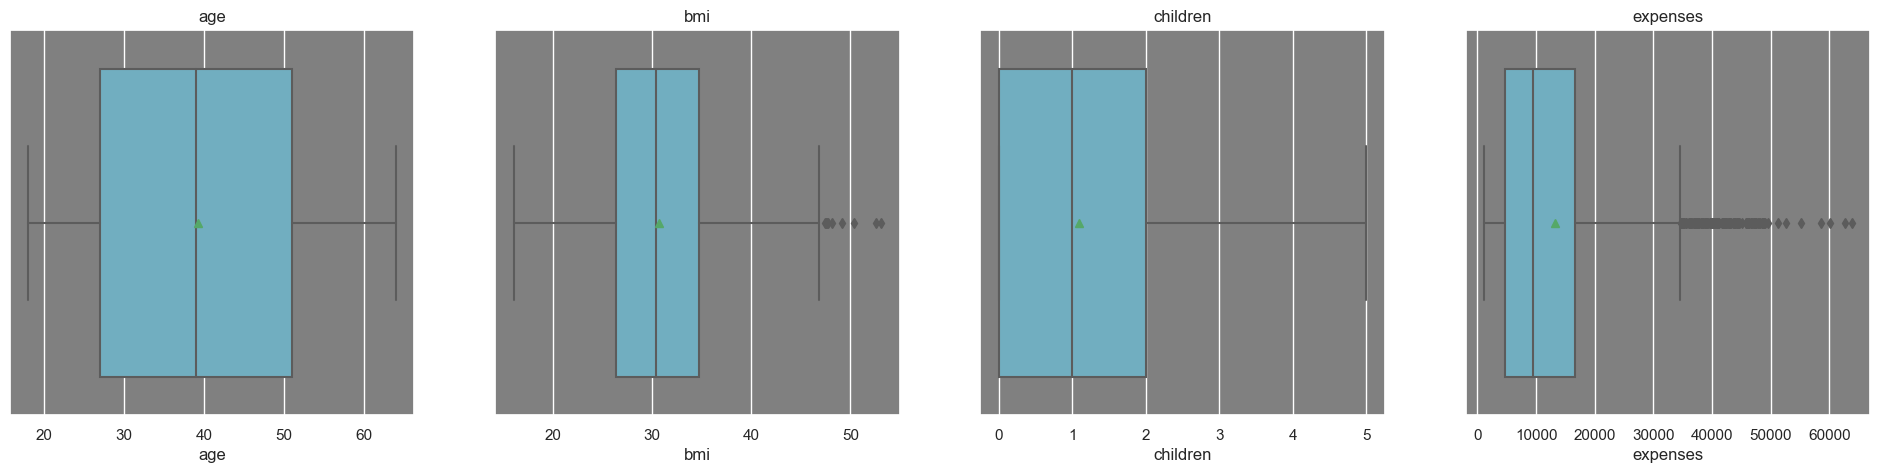

In [73]:
fig, axes = plt.subplots(1,4)   
axes = axes.flatten()        
fig.set_size_inches(24,5)
num_col = [col for col in data.columns if data[col].dtype!="O"]

for ax, col in zip(axes,num_col):
  sns.set_style("darkgrid", {"axes.facecolor": ".5"})
  sns.boxplot(data[col], ax = ax,showmeans=True,color= 'c')
  ax.set_title(col)

### Observation2:
1. Age: Following Uniform distribution. Maximum Person's Age between 18 to 20.
2. BMI: Following Normal distribution. Mean is at 30. Few outliers are present in this feature.
3. Expenses: Following power law distriution and highly right skewed.

### Region and Sex

In [74]:
print(data["region"].value_counts())


southeast    364
southwest    325
northwest    324
northeast    324
Name: region, dtype: int64


<AxesSubplot:ylabel='sex'>

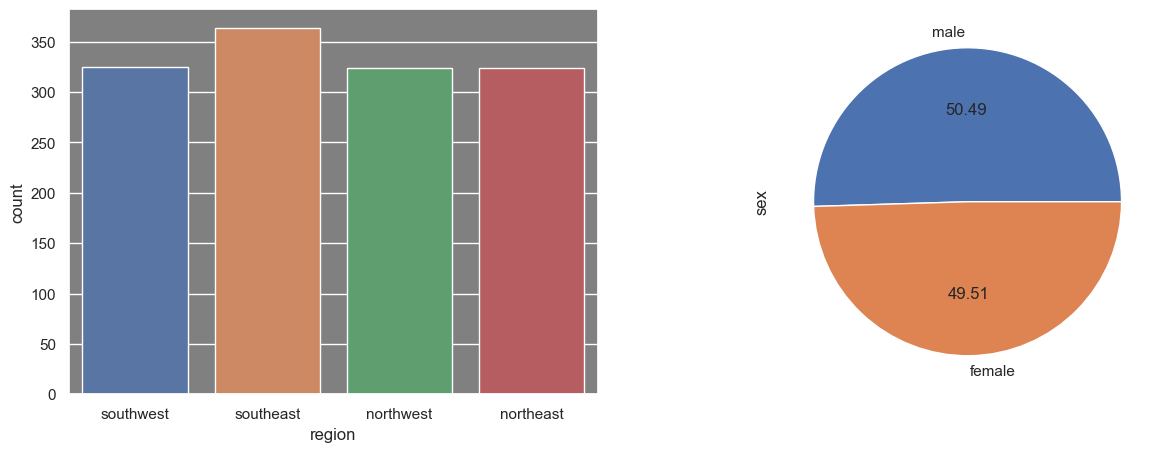

In [75]:
fig, axes = plt.subplots(1,2)   
axes = axes.flatten()        
fig.set_size_inches(15,5)
sns.set_style("darkgrid", {"axes.facecolor": ".5"})
sns.countplot(ax= axes[0], data = data, x="region")
data["sex"].value_counts().plot(kind='pie',autopct= "%.2f")

### Observation 3

1. region: No. of insured person per region are almost same.
2. sex:    almost 50% male and 50% female

### Smoker vs Sex

In [76]:
print(data["smoker"].value_counts())

no     1063
yes     274
Name: smoker, dtype: int64


<AxesSubplot:ylabel='smoker'>

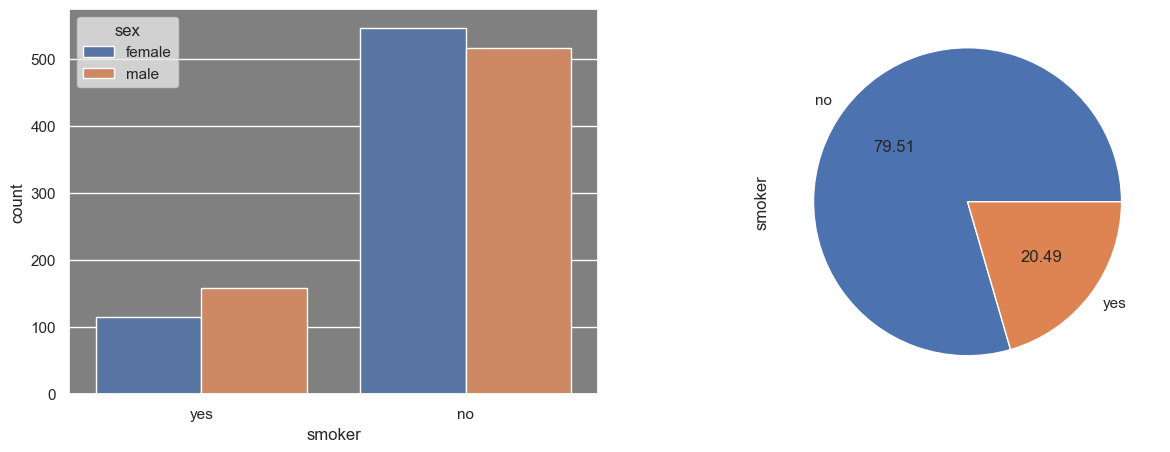

In [77]:
fig, axes = plt.subplots(1,2)   
axes = axes.flatten()        
fig.set_size_inches(15,5)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.countplot(ax= axes[0], data = data, x="smoker",hue= 'sex')
data["smoker"].value_counts().plot(kind='pie',autopct= "%.2f")

### Observation 4

only 20% of the Insure Person are smoking in which no. of male are more

### Bi-variate Anlysis

### expenses vs numerical features

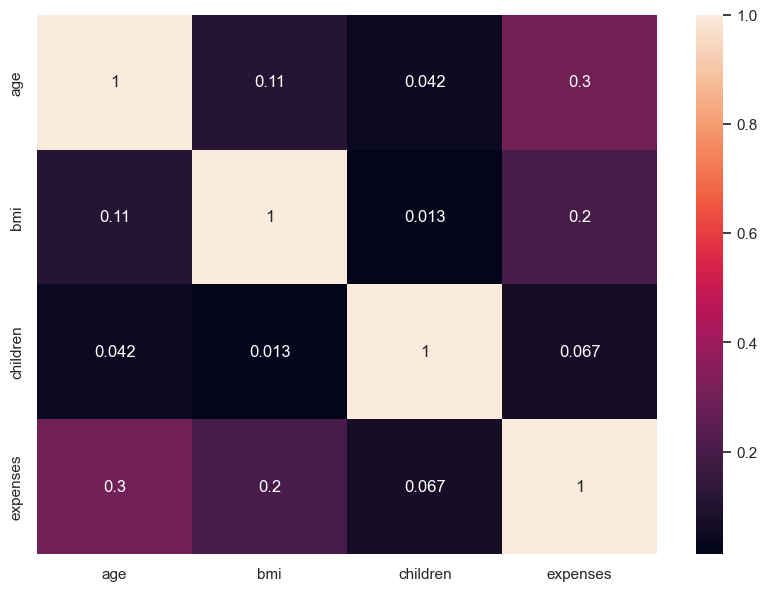

In [78]:
plt.figure(figsize= (10,7))
corr = data.corr()
ax = sns.heatmap(corr,annot=True)

 Age and Bmi have more corelation with expenses

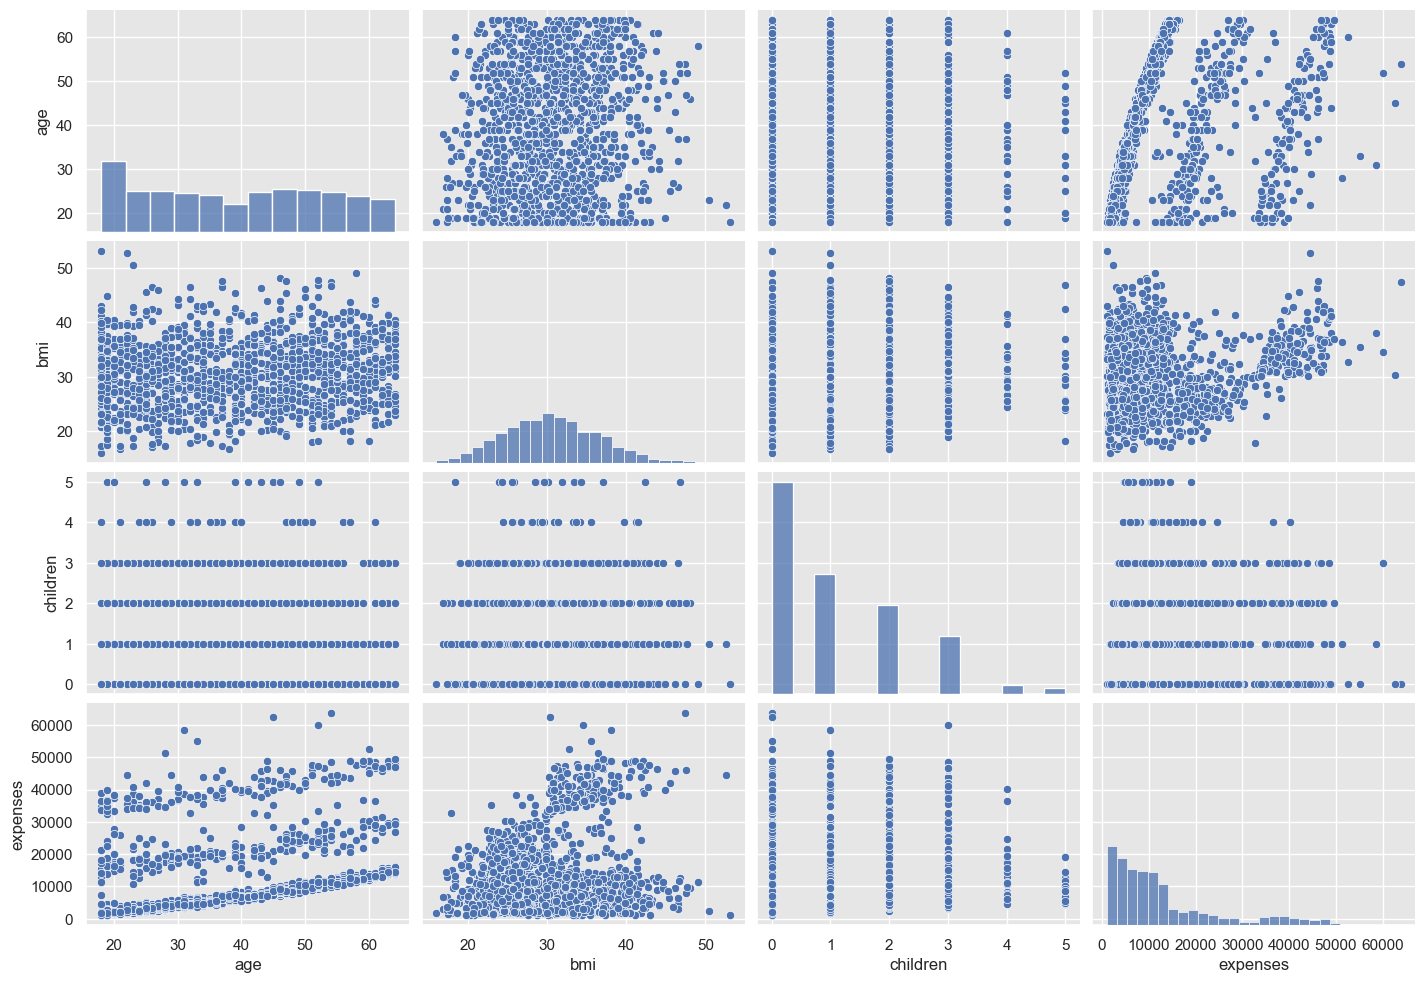

In [79]:
figure = sns.pairplot(data)
figure.fig.set_size_inches(15,10)

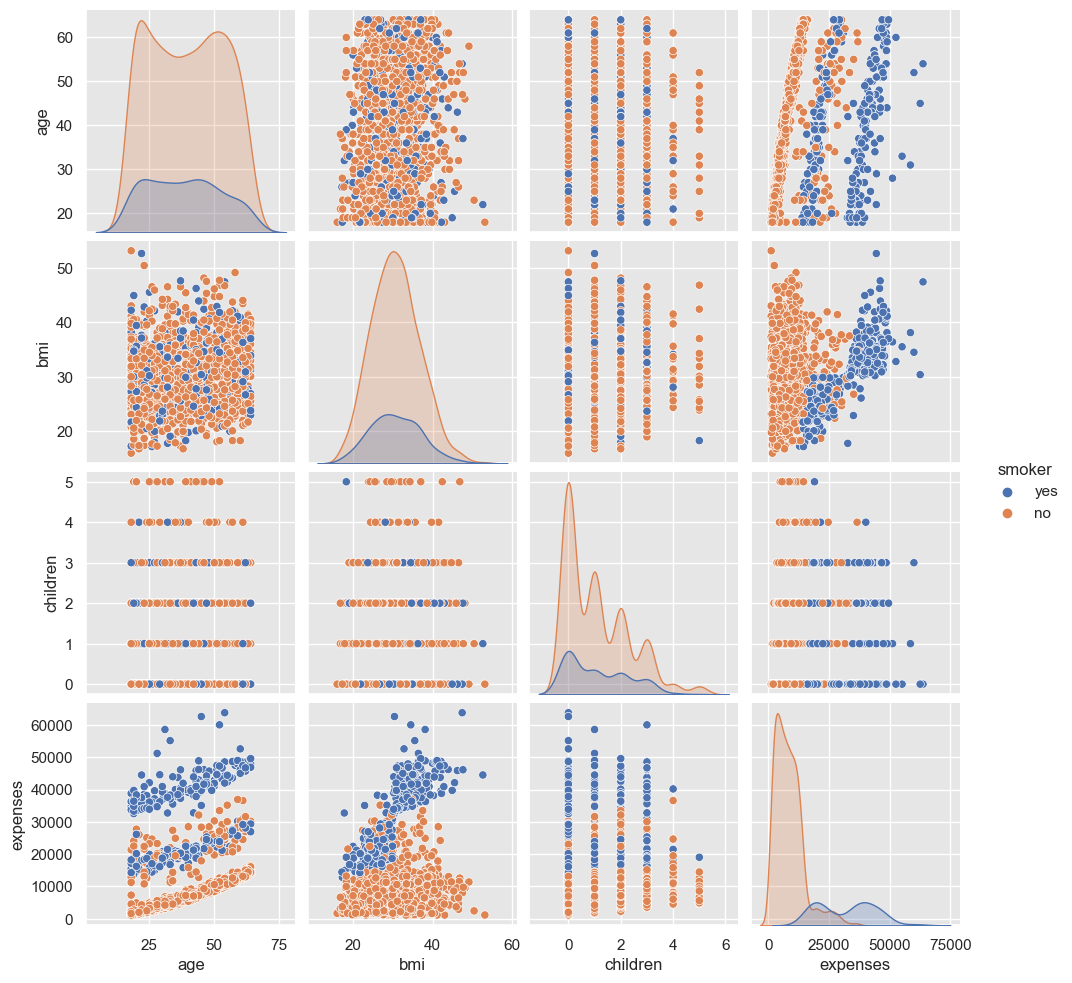

In [80]:
sns.pairplot(data,hue = 'smoker')

### Bmi Vs Expenses w.r.t smoker

Text(0.5, 1.0, 'age vs expenses')

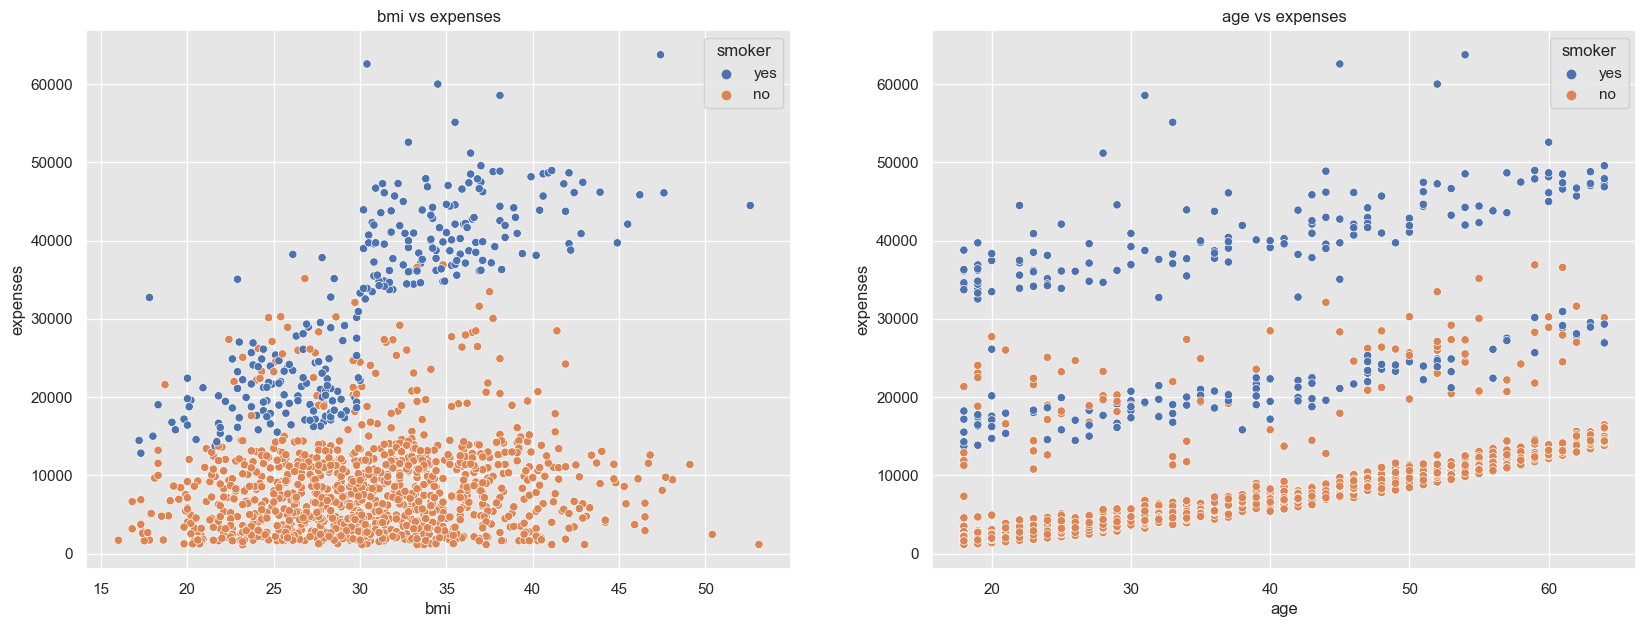

In [81]:
fig, axes = plt.subplots(1,2)   
axes = axes.flatten()        
fig.set_size_inches(20,7)
sns.scatterplot(insurance_df["bmi"],data["expenses"],ax=axes[0],hue=data["smoker"])
axes[0].set_title("bmi vs expenses")
sns.scatterplot(data["age"],data["expenses"],ax=axes[1],hue=data["smoker"])
axes[1].set_title("age vs expenses")

### categorical_features vs expenses

<AxesSubplot:xlabel='expenses', ylabel='smoker'>

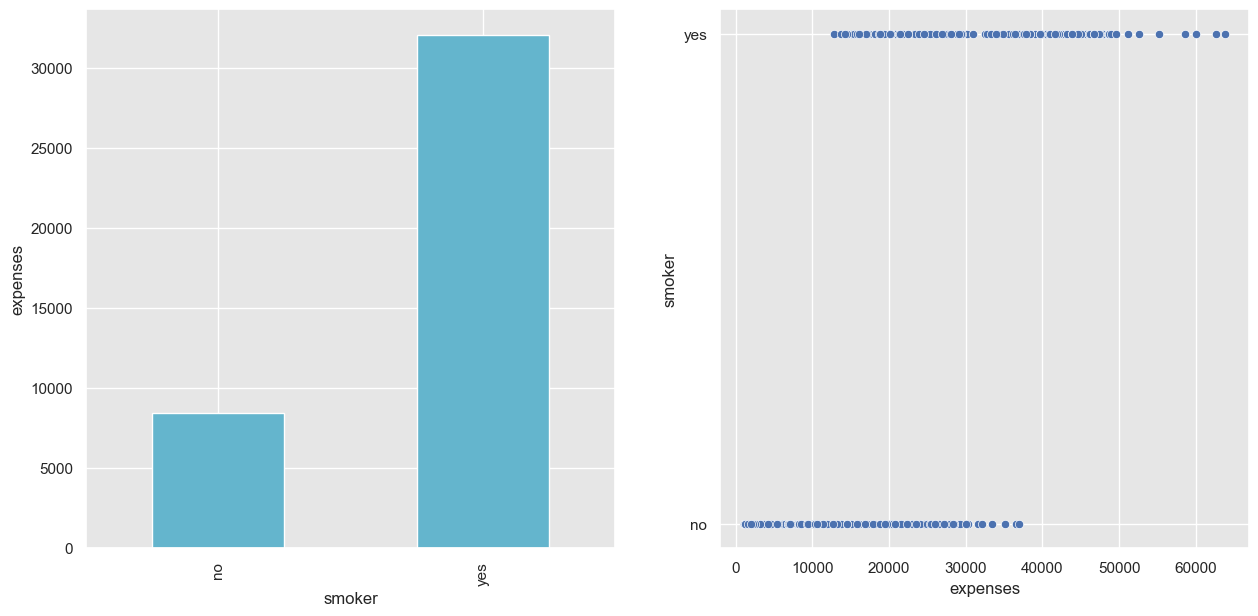

In [82]:
fig, ax =plt.subplots(1,2)
ax = ax.flatten()
fig.set_size_inches(15,7)

data.groupby("smoker")['expenses'].mean().plot(ax= ax[0],ylabel="expenses", kind= 'bar',color='c')
sns.scatterplot(data["expenses"],data["smoker"],ax = ax[1])

 when a person has smoking habit the expenses are high

<AxesSubplot:xlabel='children', ylabel='expenses'>

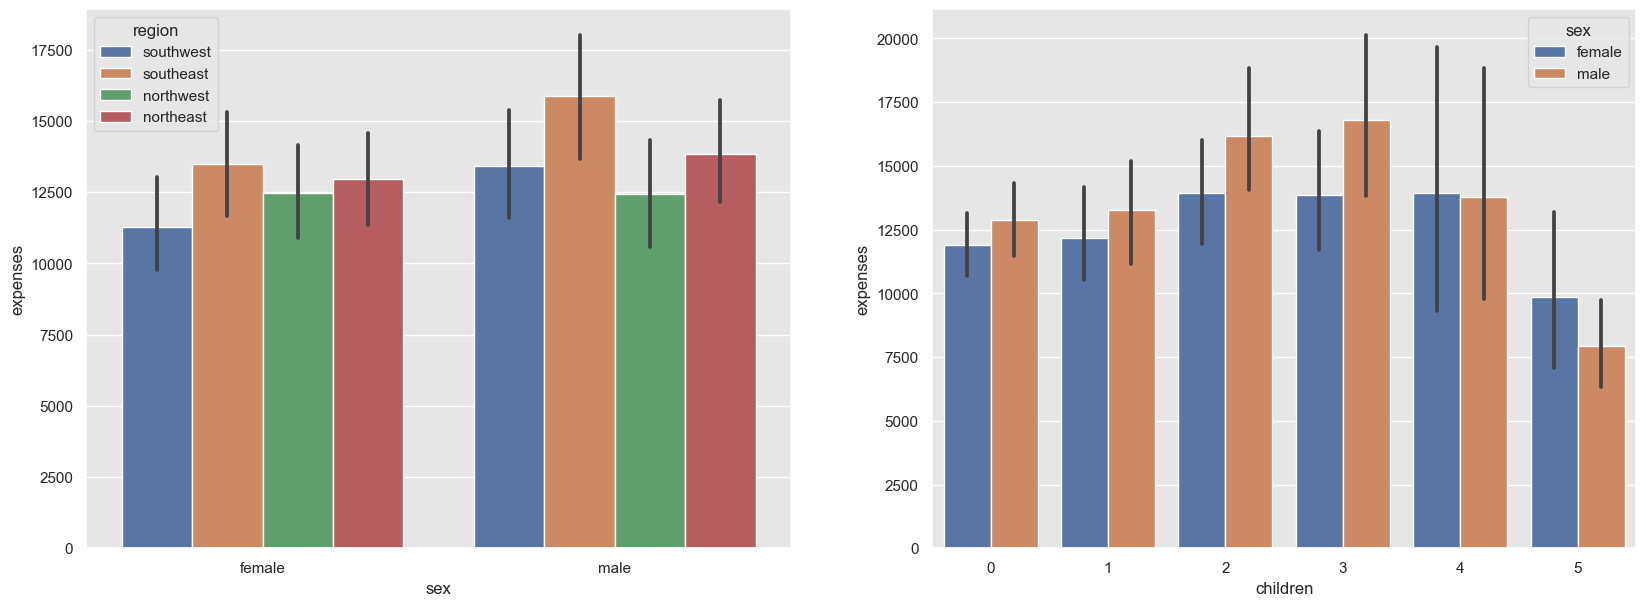

In [83]:
fig, ax =plt.subplots(1,2)
ax = ax.flatten()
fig.set_size_inches(20,7)

sns.barplot(x = "sex", y = "expenses",hue='region', data = data,ax = ax[0])
sns.barplot(x = "children", y = "expenses",hue='sex', data = data, ax= ax[1])

<AxesSubplot:xlabel='expenses', ylabel='Count'>

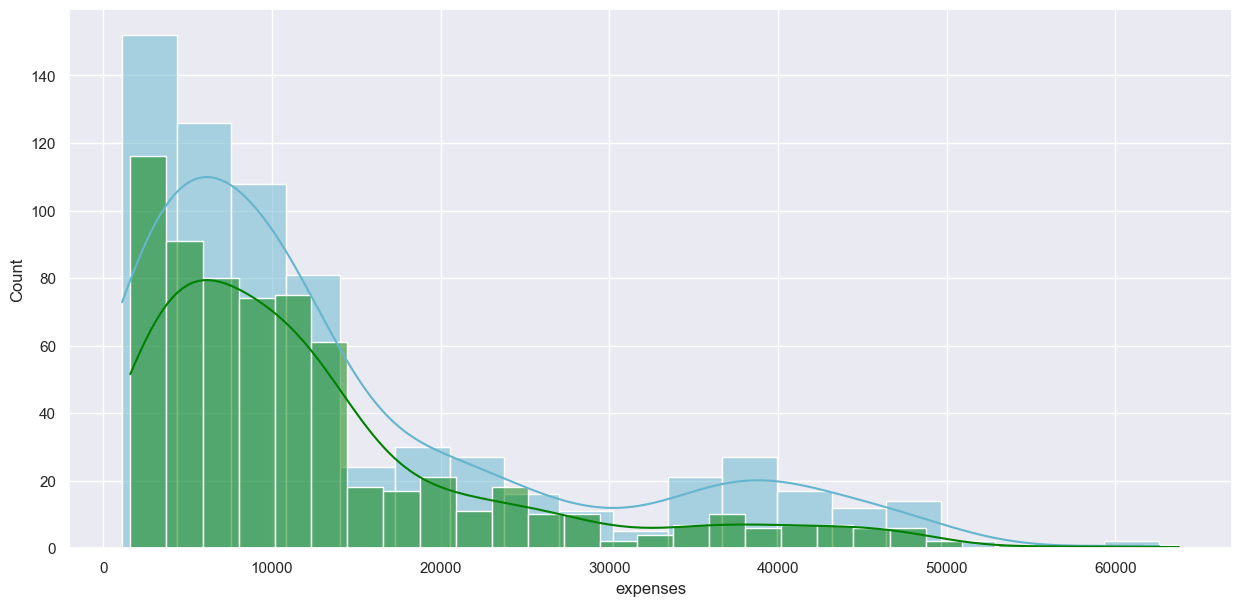

In [84]:
male = data[data["sex"]=='male']
female = data[data["sex"]=='female']

sns.set(rc = {'figure.figsize':(15,7)})
sns.histplot(male['expenses'],color= 'c',kde= True)
sns.histplot(female['expenses'],color= 'green',kde=True)

In [85]:
data["sex"]=='male'

0       False
1        True
2        True
3        True
4        True
        ...  
1333     True
1334    False
1335    False
1336    False
1337    False
Name: sex, Length: 1337, dtype: bool

<AxesSubplot:xlabel='region', ylabel='expenses'>

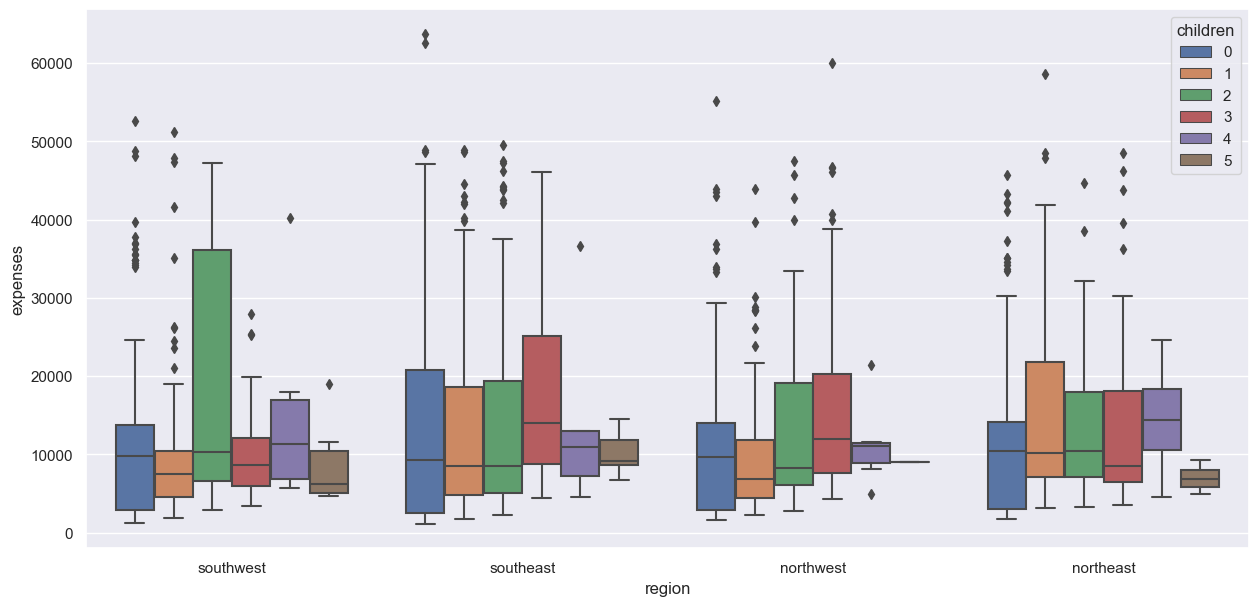

In [86]:
sns.boxplot(x='region',y='expenses',hue = 'children',data=data)


<AxesSubplot:xlabel='region', ylabel='expenses'>

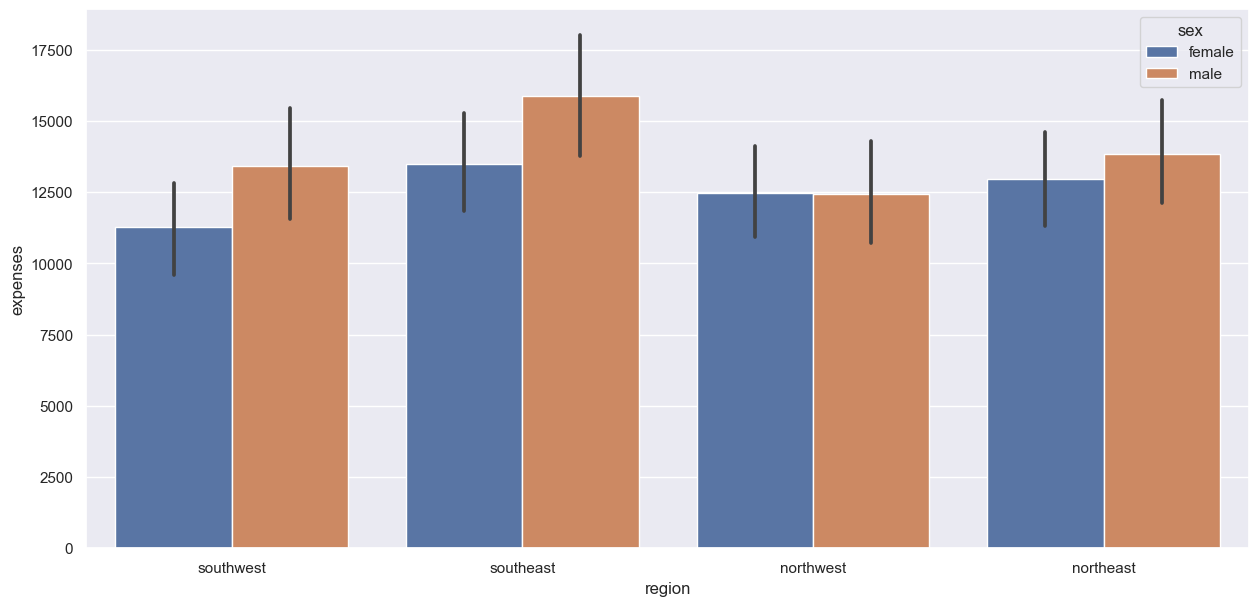

In [87]:
sns.barplot(x = "region", y = "expenses",hue='sex', data = insurance_df)

### Handling outlier in bmi

In [88]:
## this function perform imputaion with the mean of the variable where outliers are present

def detect_outlier(df,variable_name):
  outliers = []
  q1 = data["bmi"].quantile(0.25)
  q3 =data["bmi"].quantile(0.75)

  iqr = q3 - q1
  upper_fence = q3+ 1.5*iqr
  lower_fence = q1 - 1.5*iqr
  variable_mean = np.mean(df[variable_name])

  df[variable_name] = df[variable_name].apply(lambda x: variable_mean if(x<lower_fence or x>upper_fence) else x)
  return df

Text(0.5, 1.0, 'after imputing outliers')

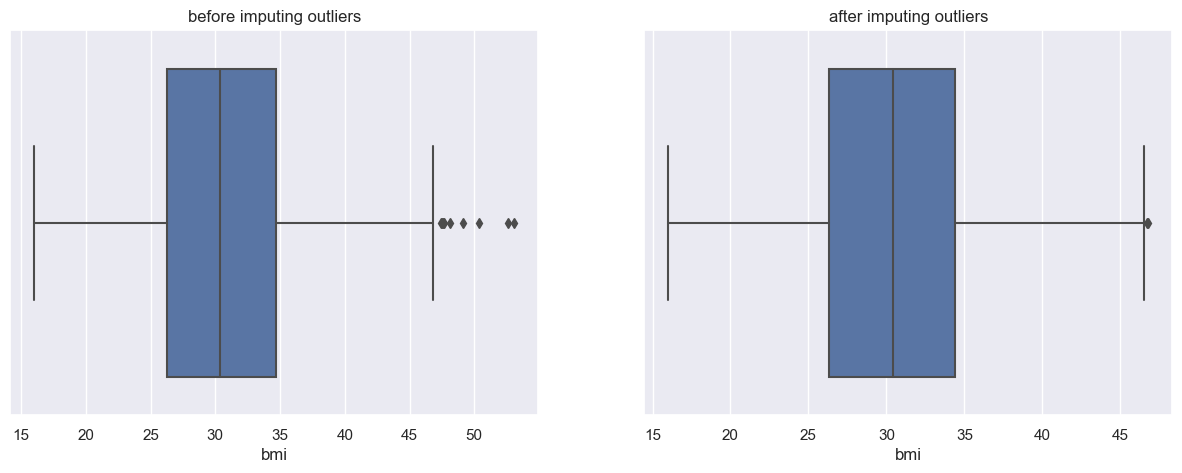

In [89]:
fig, ax =plt.subplots(1,2)
ax = ax.flatten()
fig.set_size_inches(15,5)

sns.boxplot(data["bmi"],ax = ax[0])
ax[0].set_title("before imputing outliers")
data = detect_outlier(data,'bmi')
sns.boxplot(data["bmi"],ax = ax[1])
ax[1].set_title("after imputing outliers")

### Separating numerical and categorical column

In [90]:
## Separating dependent and independent features

X,y = data.drop(columns = ["expenses"]), data['expenses']
print(X.shape)
print(y.shape)

(1337, 6)
(1337,)


In [91]:
cat_col=[]
num_col = []
[cat_col.append(col) if X[col].dtype=="O" else num_col.append(col) for col in X.columns]
print(cat_col)
print(num_col)

['sex', 'smoker', 'region']
['age', 'bmi', 'children']


#### Splitting train and test data

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=35)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape,y_test.shape)


(1002, 6)
(1002,)
(335, 6) (335,)


In [93]:
X_train.head()

,age,sex,bmi,children,smoker,region
812,54,male,21.0,2,no,southeast
548,25,female,28.6,0,no,northeast
1277,32,female,29.7,0,no,northwest
143,29,male,29.7,2,no,northwest
634,51,male,39.7,1,no,southwest


In [94]:
y_train.head()

812     11013.71
548      3213.62
1277     4357.04
143     18157.88
634      9391.35
Name: expenses, dtype: float64

### Creating Pipeline

###### Create column transformers for the preprocessing of the data

In [95]:
## transformer function for the encoding of the categorical variables using onehotencoding
categorical_encoding = OneHotEncoder(sparse=False,handle_unknown='ignore',drop='first')

### transformer function for the scaling of the numerical variables using standard scaler
numerical_scaling = StandardScaler()

data_preprocessing = ColumnTransformer(transformers=[
                              ('encoding', categorical_encoding, cat_col),
                              ('scaling', numerical_scaling, num_col)
                            ], remainder='passthrough')

##### creating pipelines with same preprocessing steps but different regressor algorithms

In [96]:
pipe_lr = Pipeline([ ("preprocessing",data_preprocessing),("regressor", LinearRegression()) ])
pipe_dt = Pipeline([("preprocessing",data_preprocessing),('regressor', DecisionTreeRegressor())])
pipe_knn = Pipeline([("preprocessing",data_preprocessing),('regressor',KNeighborsRegressor(n_neighbors=7))])
pipe_rf = Pipeline([("preprocessing",data_preprocessing),('regressor',RandomForestRegressor())])
pipe_gb = Pipeline([("preprocessing",data_preprocessing),('regressor', GradientBoostingRegressor())])
pipe_xgb  = Pipeline([("preprocessing",data_preprocessing),('regressor', XGBRegressor())])
pipelines = [pipe_lr, pipe_dt, pipe_knn, pipe_rf, pipe_gb,pipe_xgb]

pipes_dict = {0: "linear_reg",1:"Decision_tree_reg",2:"Knn_regressor",3:"Random_forest_reg",4: "Gradient_Boosting_Regressor",5:"XGB_Regressor"}

### without performing hyperparameter tuning

In [97]:
for idx, pipe in enumerate(pipelines):
    pipe.fit(X_train,y_train)
    print(f" the test accuracy score for the {pipes_dict[idx]} is :    {pipe.score(X_test,y_test)}")

 the test accuracy score for the linear_reg is :    0.7384456657712791
 the test accuracy score for the Decision_tree_reg is :    0.7571448816244932
 the test accuracy score for the Knn_regressor is :    0.6235793675514612
 the test accuracy score for the Random_forest_reg is :    0.8286195165252541
 the test accuracy score for the Gradient_Boosting_Regressor is :    0.8518954953497101
 the test accuracy score for the XGB_Regressor is :    0.8019652572509868


#### using GridsearchCV

In [98]:
params_D_Tree = {
              "regressor": [DecisionTreeRegressor()],
              "regressor__splitter":["best", "random"],
              "regressor__max_depth" : list(range(1,13)),
              "regressor__min_samples_leaf":list(range(1,13)),
              "regressor__min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
              "regressor__max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90] 
}

grid_search_DT = GridSearchCV(pipe_dt,param_grid= params_D_Tree,cv=5, verbose = 0, n_jobs = -1)
grid_search_DT.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('encoding',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['sex',
                                                                          'smoker',
                                                                          'region']),
                                                                        ('scaling',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'bmi',
                                                                          'children'])])),
                                       ('regressor', DecisionTreeRegressor())]),
             n_jobs=-1,
             param_grid={'regressor...
                                                             max_leaf_nodes=60,
                                                             min_samples_leaf=5,
                                                             min_weight_fraction_leaf=0.1)],
                         'regressor__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                                  11, 12],
                         'regressor__max_leaf_nodes': [None, 10, 20, 30, 40, 50,
                                                       60, 70, 80, 90],
                         'regressor__min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8,
                                                         9, 10, 11, 12],
                         'regressor__min_weight_fraction_leaf': [0.1, 0.2, 0.3,
                                                                 0.4, 0.5, 0.6,
                                                                 0.7, 0.8,
                                                                 0.9],
                         'regressor__splitter': ['best', 'random']})

In [99]:
grid_param_KNN = {
          "regressor": [KNeighborsRegressor()],
          "regressor__leaf_size":list(range(1,50)),
          "regressor__n_neighbors":list(range(1,30)),
          "regressor__p":[1,2]
}
grid_search_KNN = GridSearchCV(pipe_knn,param_grid= grid_param_KNN,cv=5, verbose = 0, n_jobs = -1)
grid_search_KNN.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('encoding',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['sex',
                                                                          'smoker',
                                                                          'region']),
                                                                        ('scaling',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'bmi',
                                                                          'children'])])),
                                       ('regressor',
                                        KNeighborsRegressor(n_neighbors=7))]),
             n_jobs=-1,
             param_grid={'regressor': [KNeighborsRegressor(leaf_size=2,
                                                           n_neighbors=3,
                                                           p=1)],
                         'regressor__leaf_size': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                                  11, 12, 13, 14, 15, 16, 17,
                                                  18, 19, 20, 21, 22, 23, 24,
                                                  25, 26, 27, 28, 29, 30, ...],
                         'regressor__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                    10, 11, 12, 13, 14, 15, 16,
                                                    17, 18, 19, 20, 21, 22, 23,
                                                    24, 25, 26, 27, 28, 29],
                         'regressor__p': [1, 2]})

In [100]:
grid_param_RF ={"regressor": [RandomForestRegressor()],
                 "regressor__n_estimators":[50,100,200,400], 
                 "regressor__max_depth":[2,4,5,7,9],
                 "regressor__random_state":[13]}

grid_search_RF = GridSearchCV(pipe_rf,param_grid= grid_param_RF,cv=5, verbose = 0, n_jobs = -1)
grid_search_RF.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('encoding',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['sex',
                                                                          'smoker',
                                                                          'region']),
                                                                        ('scaling',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'bmi',
                                                                          'children'])])),
                                       ('regressor', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'regressor': [RandomForestRegressor(max_depth=4,
                                                             n_estimators=200,
                                                             random_state=13)],
                         'regressor__max_depth': [2, 4, 5, 7, 9],
                         'regressor__n_estimators': [50, 100, 200, 400],
                         'regressor__random_state': [13]})

In [101]:
grid_param_GB = {
          "regressor": [GradientBoostingRegressor()],
          'regressor__n_estimators' : [10, 50, 100, 500],
          'regressor__learning_rate' : [0.0001, 0.001, 0.01, 0.1, 1.0],
          'regressor__subsample' : [0.5, 0.7, 1.0],
          'regressor__max_depth' : [3, 7, 9]
          }
grid_search_GB = GridSearchCV(pipe_gb,param_grid= grid_param_GB,cv=5, verbose = 0, n_jobs = -1)
grid_search_GB.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('encoding',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['sex',
                                                                          'smoker',
                                                                          'region']),
                                                                        ('scaling',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'bmi',
                                                                          'children'])])),
                                       ('regressor',
                                        GradientBoostingRegressor())]),
             n_jobs=-1,
             param_grid={'regressor': [GradientBoostingRegressor(learning_rate=0.01,
                                                                 n_estimators=500,
                                                                 subsample=0.7)],
                         'regressor__learning_rate': [0.0001, 0.001, 0.01, 0.1,
                                                      1.0],
                         'regressor__max_depth': [3, 7, 9],
                         'regressor__n_estimators': [10, 50, 100, 500],
                         'regressor__subsample': [0.5, 0.7, 1.0]})

In [102]:
grid_param_XGB = {
              "regressor":[XGBRegressor()],
              "regressor__max_depth":    [3, 7, 9, 4, 5],
              "regressor__n_estimators": [500, 600, 700],
              "regressor__learning_rate": [0.01, 0.015,0.0001, 0.001, 0.1, 1.0],
              'regressor__subsample' : [0.5, 0.7, 1.0],

}

grid_search_XGB = GridSearchCV(pipe_xgb,param_grid= grid_param_XGB,cv=5, verbose = 0, n_jobs = -1)
grid_search_XGB.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('encoding',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['sex',
                                                                          'smoker',
                                                                          'region']),
                                                                        ('scaling',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'bmi',
                                                                          'children'])])),
                                       ('regressor',
                                        XGBRegressor(base_score=0.5,
                                                     booster='gbtree',
                                                     callbacks=None...
                                                    min_child_weight=None,
                                                    missing=nan,
                                                    monotone_constraints=None,
                                                    n_estimators=500,
                                                    n_jobs=None,
                                                    num_parallel_tree=None,
                                                    predictor=None,
                                                    random_state=None,
                                                    reg_alpha=None,
                                                    reg_lambda=None, ...)],
                         'regressor__learning_rate': [0.01, 0.015, 0.0001,
                                                      0.001, 0.1, 1.0],
                         'regressor__max_depth': [3, 7, 9, 4, 5],
                         'regressor__n_estimators': [500, 600, 700],
                         'regressor__subsample': [0.5, 0.7, 1.0]})

In [103]:
print(f"the test accuraccy score of Decision_tree before = {pipe_dt.score(X_test,y_test)} , and after using GridSearchCV = {grid_search_DT.score(X_test,y_test)} ")
print(f"the test accuraccy score of KNN_regressor befor =  {pipe_knn.score(X_test,y_test)} , and after using GridSearchCV = {grid_search_KNN.score(X_test,y_test)} ")
print(f"the test accuraccy score of RandomForest_regressor before = {pipe_rf.score(X_test,y_test)} , and after using GridSearchCV = {grid_search_RF.score(X_test,y_test)} ")
print(f"the test accuraccy score of GradientBoosting_regressor before = {pipe_gb.score(X_test,y_test)} , and after using GridSearchCV = {grid_search_GB.score(X_test,y_test)} ")
print(f"the test accuraccy score of XGBoost_regressor before = {pipe_xgb.score(X_test,y_test)} , and after using GridSearchCV = {grid_search_GB.score(X_test,y_test)} ")

the test accuraccy score of Decision_tree before = 0.7571448816244932 , and after using GridSearchCV = 0.670638515118239 
the test accuraccy score of KNN_regressor befor =  0.6235793675514612 , and after using GridSearchCV = 0.6804315770502389 
the test accuraccy score of RandomForest_regressor before = 0.8286195165252541 , and after using GridSearchCV = 0.8469957962731507 
the test accuraccy score of GradientBoosting_regressor before = 0.8518954953497101 , and after using GridSearchCV = 0.8519018654272836 
the test accuraccy score of XGBoost_regressor before = 0.8019652572509868 , and after using GridSearchCV = 0.8519018654272836 


#### Observation
1. After using GridsearchCV ,accuracy of the RandomForest_regressor, GradientBoosting_regressor, XGB_regressor, KNN_regressor has been increased.
2. And the accuracy of Decision tree decreased.

### Update the pipeline with best params

In [104]:
grid_search_XGB.best_params_

{'regressor': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None,
              reg_alpha=None, reg_lambda=None, ...),
 'regressor__learning_rate': 0.01,
 'regressor__max_depth': 3,
 'regressor__n_estimators': 500,
 'regressor__subsample': 1.0}

In [125]:
pipe_lr = Pipeline([ ("preprocessing",data_preprocessing),("regressor", LinearRegression()) ])
pipe_dt = Pipeline([("preprocessing",data_preprocessing),('regressor', DecisionTreeRegressor())])
pipe_knn = Pipeline([("preprocessing",data_preprocessing),('regressor',KNeighborsRegressor(leaf_size=7, n_neighbors=3, p=1))])
pipe_rf = Pipeline([("preprocessing",data_preprocessing),('regressor',RandomForestRegressor(max_depth=4, n_estimators=200, random_state=13))])
pipe_gb = Pipeline([("preprocessing",data_preprocessing),('regressor', GradientBoostingRegressor(learning_rate=0.01, n_estimators=500, subsample=0.7))])
pipe_xgb  = Pipeline([("preprocessing",data_preprocessing),('regressor', XGBRegressor(learning_rate=0.01, n_estimators=500, subsample=1.0))])
pipelines = [pipe_lr, pipe_dt, pipe_knn, pipe_rf, pipe_gb,pipe_xgb]
pipes_dict = {0: "linear_reg",1:"Decision_tree_reg",2:"Knn_regressor",3:"Random_forest_reg",4: "Gradient_Boosting_Regressor",5:"XGB_Regressor"}

### Evaluate the metrics for all the models

In [126]:
### function to calculate the evaluation metrics

def evaluate_model(model,y_actual,y_pred):
  
  model_metrics = pd.DataFrame({"model_name":[model],
                "mse" : [np.round(mean_squared_error(y_actual,y_pred),4)],
                "rmse" : [np.sqrt(mean_squared_error(y_actual,y_pred))],
                "mae" : [mean_absolute_error(y_actual,y_pred)],
                "r2" : [r2_score(y_actual,y_pred)]
  })
  return model_metrics

In [128]:
metrics_df = pd.DataFrame()

for idx, pipe in enumerate(pipelines):
  model = pipes_dict[idx]
  y_pred= pipe.predict(X_test)
  
  metrics = evaluate_model(model, y_test,y_pred)
  metrics_df = metrics_df.append(metrics, ignore_index=True)